### **Objective of the project**

The objective of this project is to efficiently process a large dataset of images to compute the mean face representation using PyTorch. The steps involve:

1. **Data Loading**:
   - Load the dataset and preprocess images using transformations like resizing and normalization.

2. **Custom Data Handling**:
   - Define a collate function to ensure seamless data transfer to the GPU for efficient batch processing.

3. **Mean Face Calculation**:
   - Process the dataset in batches to compute the cumulative sum of pixel values and the total count of images.
   - Utilize GPU acceleration and multi-threading to optimize the computation.

4. **Visualization**:
   - Display the computed mean face to verify the results and understand the dataset's average representation.

The project is aimed to leverage PyTorch's capabilities for high-performance data processing and efficient GPU utilization.

Python version used : 3.9

In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset 


In [273]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [274]:
# Declare constants
isUsedWholeDataSet = False
maxSubSet = 100000

### **Image Transformation and Batch Collation**

We define image preprocessing and batch handling for efficient data loading and GPU utilization.

---
 

In [275]:
# Define transformation for resizing and normalizing images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
]) 

In [276]:
# Define a collate function to move each batch to GPU
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images).to(device)  # Stack images and move to GPU
    labels = torch.tensor(labels).to(device)  # Convert labels to tensor and move to GPU
    return images, labels


### **Dataset Loading and DataLoader Initialization**

We set up the dataset and data loader for efficient batch processing.

---



In [ ]:
# Load the full dataset
dataset = datasets.ImageFolder(root="./img_align_celeba", transform=transform)

selectDataSet = dataset if isUsedWholeDataSet else Subset(
    dataset, range(maxSubSet))

# Create DataLoader with the custom collate function
batch_size = 2048*2   # Adjust based on your GPU memory
dataloader = DataLoader(selectDataSet, batch_size=batch_size,shuffle=False)


In [278]:
print(f"Number of samples in selectDataSet: {len(selectDataSet)}")


Number of samples in selectDataSet: 100000


In [279]:
firstBatch = next(iter(dataloader))

(firstBatchImages,firstBatchLabel) = firstBatch

In [280]:
firstBatchImages[1].size()

torch.Size([3, 128, 128])

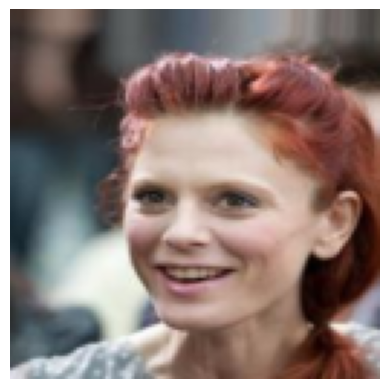

In [281]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Get the first image from the batch
image = firstBatchImages[1]

# Convert the tensor image to a format suitable for displaying
image = F.to_pil_image(image)

# Display the image
plt.imshow(image)
plt.axis('off')  # Optional: Turn off the axes
plt.show()


# Multi-GPU Support for Mean Face Calculation

### **Overview**
We define a custom PyTorch model (`MeanFaceModel`) for calculating the mean face and sets it up for multi-GPU usage using `torch.nn.DataParallel`.

---


In [282]:
import time

def measure_time(processing_function):
    start_time = time.time()
    processing_function()
    total_time = time.time() - start_time
    return total_time

In [283]:
import torch.nn as nn

# Define a simple model to compute the mean
class MeanFaceModel(nn.Module):
    def __init__(self):
        super(MeanFaceModel, self).__init__()
        

    def forward(self, images):
        # Accumulate sum and count
        batch_sum = images.sum(dim=0)  # Sum over the batch
        batch_size = images.size(0)
        return batch_sum, batch_size
    
model = MeanFaceModel().to(device)
# model = nn.DataParallel(model).to(device)  # Enable multi-GPU support

In [4]:
# Get GPU properties
device_id = 0  # Use the first GPU (or change if using multiple GPUs)
device_properties = torch.cuda.get_device_properties(device_id)

# Calculate the number of CUDA cores
cuda_cores_per_sm = {
    "3.0": 192,  # Kepler
    "3.5": 192,
    "3.7": 192,
    "5.0": 128,  # Maxwell
    "5.2": 128,
    "5.3": 128,
    "6.0": 64,   # Pascal
    "6.1": 128,
    "6.2": 128,
    "7.0": 64,   # Volta
    "7.5": 64,   # Turing
    "8.0": 64,   # Ampere
    "8.6": 128,  # Ampere
    "8.9": 128   # Ada Lovelace
}
compute_capability = f"{device_properties.major}.{device_properties.minor}"
cores_per_sm = cuda_cores_per_sm.get(compute_capability, "Unknown")
total_cores = device_properties.multi_processor_count * cores_per_sm

# Display information
print(f"Device: {device_properties.name}")
print(f"Number of Streaming Multiprocessors: {device_properties.multi_processor_count}")
print(f"Total CUDA Cores: {total_cores}")


Device: NVIDIA GeForce RTX 4070 Laptop GPU
Number of Streaming Multiprocessors: 36
Total CUDA Cores: 4608


### **Mean Face Calculation Process**

This process involves calculating the average pixel values (mean face) from a dataset using PyTorch. The key steps include:

1. **Initialization**:
   - A tensor (`total_sum`) is initialized to accumulate pixel values.
   - A counter (`total_count`) is used to keep track of the number of images processed.

2. **Data Loading and GPU Computation**:
   - Images are loaded in batches using a PyTorch `DataLoader`.
   - Each batch is moved to the GPU for processing in `float16` precision for efficiency.
   - The model processes the images to compute the sum of pixel values (`batch_sum`) and the batch size (`batch_size`).
   - The results are accumulated into `total_sum` and `total_count`.

3. **Final Calculation**:
   - The mean face is calculated by dividing `total_sum` by `total_count`.
   - The result is moved back to the CPU and converted to NumPy for visualization.

---

In [287]:
import numpy as np
import torch

# Initialize mean_face_np to a NumPy array with default values
mean_face_np = np.zeros((1, 1, 1), dtype=np.float32)  # Placeholder shape and dtype

def calculate_mean_face_gpu():
    global mean_face_np  # Declare mean_face_np as global to modify it at the global level
    
    # Initialize a tensor to accumulate pixel values
    total_sum = torch.zeros(3, 128, 128, device=device)  # Example dimensions: 3 channels, 128x128
    total_count = 0

    # Iterate through the dataloader
    for images, _ in dataloader:
        # Move images to GPU in FP16
        images = images.to(device, dtype=torch.float16)
        
        # Use model to calculate batch_sum and batch_size
        batch_sum, batch_size = model(images)
        
        # Accumulate results in FP32 for stability
        total_sum += batch_sum.to(torch.float32)
        total_count += batch_size

        # Print progress
        print(f'{total_count} out of {len(selectDataSet)} processed')

    # Compute the average (mean face)
    mean_face = total_sum / total_count 
    # Move the result back to CPU for visualization
    mean_face_np = mean_face.permute(1, 2, 0).cpu().numpy() 

# Measure GPU processing time
gpu_time = measure_time(calculate_mean_face_gpu)
print(f"GPU processing time: {gpu_time:.4f} seconds")


4096 out of 100000 processed
8192 out of 100000 processed
12288 out of 100000 processed
16384 out of 100000 processed
20480 out of 100000 processed
24576 out of 100000 processed
28672 out of 100000 processed
32768 out of 100000 processed
36864 out of 100000 processed
40960 out of 100000 processed
45056 out of 100000 processed
49152 out of 100000 processed
53248 out of 100000 processed
57344 out of 100000 processed
61440 out of 100000 processed
65536 out of 100000 processed
69632 out of 100000 processed
73728 out of 100000 processed
77824 out of 100000 processed
81920 out of 100000 processed
86016 out of 100000 processed
90112 out of 100000 processed
94208 out of 100000 processed
98304 out of 100000 processed
100000 out of 100000 processed
GPU processing time: 84.7658 seconds


### **Image Result**

 

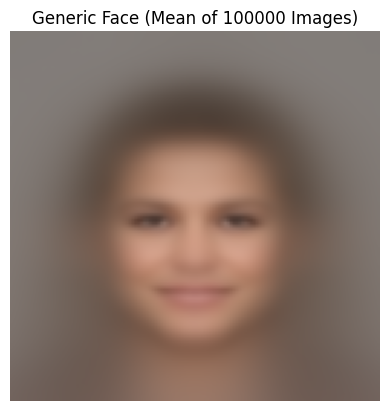

In [288]:
# Plot the "average" face
plt.imshow(mean_face_np)
plt.axis('off')
plt.title(f'Generic Face (Mean of {len(selectDataSet)} Images)')
plt.show()

# Parallelizing Mean Face Calculation with ThreadPoolExecutor

### **Overview**
This cell demonstrates how to parallelize the computation of the mean face using Python's `ThreadPoolExecutor`. Each batch of images is processed concurrently by worker threads, reducing the overall processing time.

---

### **Steps Involved**

1. **Helper Function**:
   - `process_batch(batch)`: Processes a single batch of images by transferring them to the GPU, computing the batch sum and size, and returning these values.

2. **Initialize Totals**:
   - `total_sum` accumulates pixel values.
   - `total_count` keeps track of the number of images processed.

3. **ThreadPoolExecutor**:
   - The `executor.map()` function distributes the processing of batches across multiple threads (`max_workers=5`).

4. **Result Aggregation**:
   - After processing all batches in parallel, the results (`batch_sum` and `batch_size`) are aggregated to compute the mean face.

5. **Visualization**:
   - The mean face tensor is converted to NumPy and visualized.

---

In [289]:
from concurrent.futures import ThreadPoolExecutor
# Initialize mean_face_np to a NumPy array with default values
mean_face_np = np.zeros((1, 1, 1), dtype=np.float32)  # Placeholder shape and dtype

def calculate_mean_face_threadpool():
    def process_batch(batch):
        images, _ = batch
        images = images.to(device, dtype=torch.float16)  # Move to GPU
        batch_sum, batch_size = model(images)  # Model computation
        return batch_sum.to(torch.float32), batch_size

    # Initialize totals
    total_sum = torch.zeros(3, 128, 128, device=device, dtype=torch.float32)
    total_count = 0

    # Use ThreadPoolExecutor for parallelism
    with ThreadPoolExecutor(max_workers=5) as executor:  # Adjust workers
        results = list(executor.map(process_batch, dataloader))

    # Aggregate results
    for batch_sum, batch_size in results:
        total_sum += batch_sum
        total_count += batch_size
        print(f'{total_count} out of {len(selectDataSet)}')


    # Compute mean face
    mean_face = total_sum / total_count

    # Convert to NumPy for visualization
    mean_face_np = mean_face.permute(1, 2, 0).cpu().numpy()

threadpool_mean_face_gpu = measure_time(calculate_mean_face_threadpool)
print(f"GPU with threadpool processing time: {threadpool_mean_face_gpu:.4f} seconds")


4096 out of 100000
8192 out of 100000
12288 out of 100000
16384 out of 100000
20480 out of 100000
24576 out of 100000
28672 out of 100000
32768 out of 100000
36864 out of 100000
40960 out of 100000
45056 out of 100000
49152 out of 100000
53248 out of 100000
57344 out of 100000
61440 out of 100000
65536 out of 100000
69632 out of 100000
73728 out of 100000
77824 out of 100000
81920 out of 100000
86016 out of 100000
90112 out of 100000
94208 out of 100000
98304 out of 100000
100000 out of 100000
GPU with threadpool processing time: 89.1473 seconds


### **Why the Normal For Loop is Faster than Concurrency**

1. **Thread Overhead**:
   - Using `ThreadPoolExecutor` introduces additional overhead for creating, managing, and synchronizing threads. This overhead becomes a bottleneck for GPU-heavy tasks where the GPU can handle computations efficiently without threading.

2. **Global Interpreter Lock (GIL)**:
   - Python's GIL restricts true parallelism for CPU-bound tasks when using threads. This limitation leads to minimal benefits when processing batches concurrently on the CPU.

3. **Efficient GPU Utilization**:
   - The normal for loop processes one batch at a time, maximizing GPU utilization. In contrast, concurrent threads introduce delays when transferring batches to the GPU, resulting in inefficient GPU usage.

4. **Disruption of `DataLoader` Optimization**:
   - PyTorch's `DataLoader` is optimized for sequential prefetching and caching. Concurrency interferes with these optimizations, causing additional delays.

5. **GPU-Bound Workload**:
   - Since the workload primarily relies on the GPU, adding concurrency on the CPU adds unnecessary overhead without improving performance. GPU operations are already parallelized internally.

---

### **Key Takeaway**
For GPU-heavy operations, a normal for loop is faster because:
- It avoids the thread management overhead.
- It fully utilizes PyTorch's efficient data loading and GPU execution pipeline.


### **Comparing CPU to GPU performance**

Here we introduce two functions - `process_batch_cpu` and `process_batch_gpu` to ensure that the batches are either computed on the CPU or GPU respectively. We also use a function `measure_time` to collect the performance data of both `process_batch_cpu` and `process_batch_gpu`. These results are then displayed on a graph with the `matplotlib` library.

4096 out of 100000 processed on CPU
8192 out of 100000 processed on CPU
12288 out of 100000 processed on CPU
16384 out of 100000 processed on CPU
20480 out of 100000 processed on CPU
24576 out of 100000 processed on CPU
28672 out of 100000 processed on CPU
32768 out of 100000 processed on CPU
36864 out of 100000 processed on CPU
40960 out of 100000 processed on CPU
45056 out of 100000 processed on CPU
49152 out of 100000 processed on CPU
53248 out of 100000 processed on CPU
57344 out of 100000 processed on CPU
61440 out of 100000 processed on CPU
65536 out of 100000 processed on CPU
69632 out of 100000 processed on CPU
73728 out of 100000 processed on CPU
77824 out of 100000 processed on CPU
81920 out of 100000 processed on CPU
86016 out of 100000 processed on CPU
90112 out of 100000 processed on CPU
94208 out of 100000 processed on CPU
98304 out of 100000 processed on CPU
100000 out of 100000 processed on CPU
CPU processing time: 91.3476 seconds


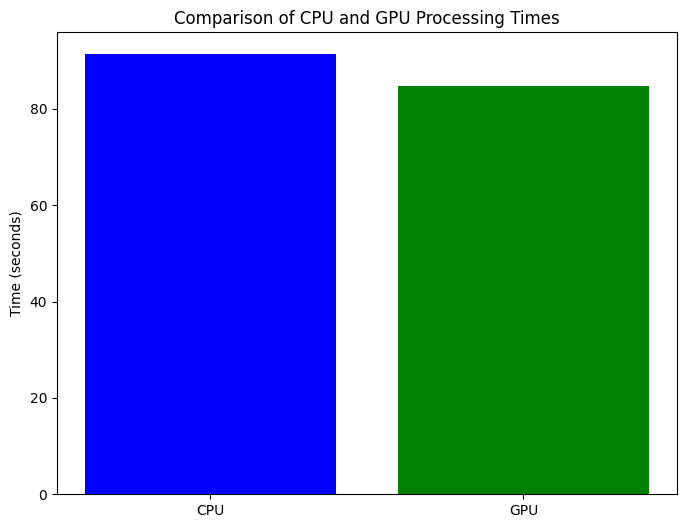

In [290]:
import torch
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

# Function to process batches (CPU)

mean_face_np = np.zeros((1, 1, 1), dtype=np.float32)  # Placeholder shape and dtype

def process_batch_cpu():
    total_sum = torch.zeros(3, 128, 128, device='cpu')
    total_count = 0
    for images, _ in dataloader: 
        images = images.to('cpu', dtype=torch.float16)

        batch_sum = images.sum(dim=0)  # Sum over the batch
        batch_size = images.size(0)
        # Convert the batch sum to FP32 for stability when adding to total
        total_sum += batch_sum.to(torch.float32)
        
        # Update the count with the batch size 
        total_count += batch_size
        
        # Print progress
        print(f'{total_count} out of {len(selectDataSet)} processed on CPU')
    # Compute the average (mean face)
    mean_face = total_sum / total_count 
    mean_face_np = mean_face.permute(1, 2, 0).numpy() 
 
# Measure time for CPU processing
cpu_time = measure_time(process_batch_cpu)
print(f"CPU processing time: {cpu_time:.4f} seconds")



# Create a bar plot to compare CPU and GPU times
times = [cpu_time, gpu_time]
labels = ['CPU', 'GPU']

plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=['blue', 'green'])
plt.ylabel('Time (seconds)')
plt.title('Comparison of CPU and GPU Processing Times')
plt.show()